# Simple neural network for MBL-ETH Transition

In [1]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
tf.set_random_seed(seed)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina' #plot high-res img 

Using TensorFlow backend.


## Use entanglement spectrum to feed the network
$j=5.0$ data represent typical the thermal phase, $j=0.1$ for the MBL phase 

In [2]:
# Load the example data set with L=12
# p1 represents the localized MBL phase while p2 is ETH phase
x = np.load('phase_1.npz')
p1 = x['ent']
x = np.load('phase_2.npz')
p2 = x['ent']
print(p1.shape,p2.shape)

(6560, 128) (6560, 128)


In [ ]:
# This is only useful if you run the en_spectrum.py script to generate your own data set
L = 12
runs = 4 # number of samples generated
loaded = np.load('1en_spectrum_L=12_j=0.1.npz')

dim= len(loaded['ent']) # the dim is determined by the cut position
x = np.zeros((runs,dim,2**(int(L//2+1))), dtype='float64')
for i in range(runs):
    filename = ""+str(i+1)+"en_spectrum_L=12_j=0.1.npz"
    loaded = np.load(filename)
    x[i] = loaded['ent']
p1 = np.concatenate((x[:])) 

runs = 4
x = np.zeros((runs,dim,2**(int(L//2+1))), dtype='float64')
for i in range(runs):
    filename = ""+str(i+1)+"en_spectrum_L=12_j=5.0.npz"
    loaded = np.load(filename)
    x[i] = loaded['ent']
p2 = np.concatenate((x[:])) 

# cast the original data to single precision to speed up
p1 = p1.astype('float32')
p2 = p2.astype('float32')
print(p1.shape, p2.shape)

## Use wavefunction(absolute value squared) as raw data to feed the network

In [ ]:
# Load the wavefunction data
x = np.load('phase_1.npz')
p1 = x['wav']
x = np.load('phase_2.npz')
p2 = x['wav']
print(p1.shape,p2.shape)

In [ ]:
# This is only useful if you run the en_spectrum.py script to generate your own data set
L = 12
runs = 4
dim = int(2**(L-1))
x = np.zeros((runs, 200, dim), dtype='float64')
for i in range(runs):
    filename = ""+str(i+1)+"en_spectrum_L=12_j=0.1.npz"
    loaded = np.load(filename)
    wav = loaded['wave']
    abswav = np.multiply(wav,np.conj(wav))
    x[i] = np.multiply(wav,np.conj(wav))
p1 = np.concatenate((x[:]))

runs = 4
x = np.zeros((runs, 200, dim), dtype='float64')
for i in range(runs):
    filename = ""+str(i+1)+"en_spectrum_L=12_j=5.0.npz"
    loaded = np.load(filename)
    wav = loaded['wave']
    abswav = np.multiply(wav,np.conj(wav))
    x[i] = np.multiply(wav,np.conj(wav))
p2 = np.concatenate((x[:]))

p1 = p1.astype('float32')
p2 = p2.astype('float32')
print(p1.shape, p2.shape)

### Label two phases and partition trainning and test set

In [3]:
#combine entanglement spectrum of different system sizes with 2 labels
num_classes = 2
l1=np.ones(p1.shape[0],dtype=np.int8)
l2=np.zeros(p2.shape[0],dtype=np.int8)
ph1=np.column_stack((l1,p1))
ph2=np.column_stack((l2,p2))
dat=np.concatenate((ph1,ph2))
#shuffle the data
dat=np.random.permutation(dat)

# divide div% of data as training set
div=0.8
X_train=dat[:int(np.ceil(div*len(dat))),1:]
Y_train=dat[:int(np.ceil(div*len(dat))),:1].reshape(-1)

X_test=dat[int(np.floor(div*len(dat)+1)):,1:]
Y_test=dat[int(np.floor(div*len(dat)+1)):,:1].reshape(-1)

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print(X_train.shape, Y_train.shape, Y_test.shape)

(10496, 128) (10496, 2) (2623, 2)


## Create the neural network

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization

def create_model():
    # instantiate model
    model = Sequential()
    # add a normalization layer to improve robustness
    model.add(BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001))
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(X_test.shape[1],), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(50, activation='relu'))
    # apply dropout with rate 0.4
    model.add(Dropout(0.4))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model with loss function and optimizer
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

### Train the model

In [5]:
# training parameters
batch_size = 150
epochs = 10

from keras.callbacks import EarlyStopping
#early termination to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# create the deep neural net
model_DNN=create_model()

# train DNN and store training info in history
history=model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),callbacks=[early_stopping])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10496 samples, validate on 2623 samples
Epoch 1/10
10496/10496 [==============================] - 2s 203us/step - loss: 0.4291 - acc: 0.7978 - val_loss: 0.2063 - val_acc: 0.9211
Epoch 2/10
10496/10496 [==============================] - 1s 50us/step - loss: 0.2049 - acc: 0.9167 - val_loss: 0.1454 - val_acc: 0.9421
Epoch 3/10
10496/10496 [==============================] - 1s 51us/step - loss: 0.1339 - acc: 0.9473 - val_loss: 0.1313 - val_acc: 0.9413
Epoch 4/10
10496/10496 [==============================] - 1s 50us/step - loss: 0.1124 - acc: 0.9559 - val_loss: 0.1273 - val_acc: 0.9474
Epoch 5/10
10496/10496 [==============================] - 1s 51us/step - loss: 0.0915 - acc: 0.9650 - val_loss: 0.1380 - val_acc: 0.9462
Epoch 6/10
10496/10496 [==========================

#### Optional: Save trained model which can be trained later

In [ ]:
#save the model and continue training
model_DNN.save('my_model.h5')
from keras.models import load_model
model_DNN = load_model('my_model.h5')


# training parameters
batch_size = 100
epochs = 10

# create the deep neural net
# model_DNN=compile_model()

# train DNN and store training info in history
history=model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),callbacks=[early_stopping])

### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

2623/2623 [==============================] - 0s 34us/step

Test loss: 0.11848612011240223
Test accuracy: 0.9542508574555586


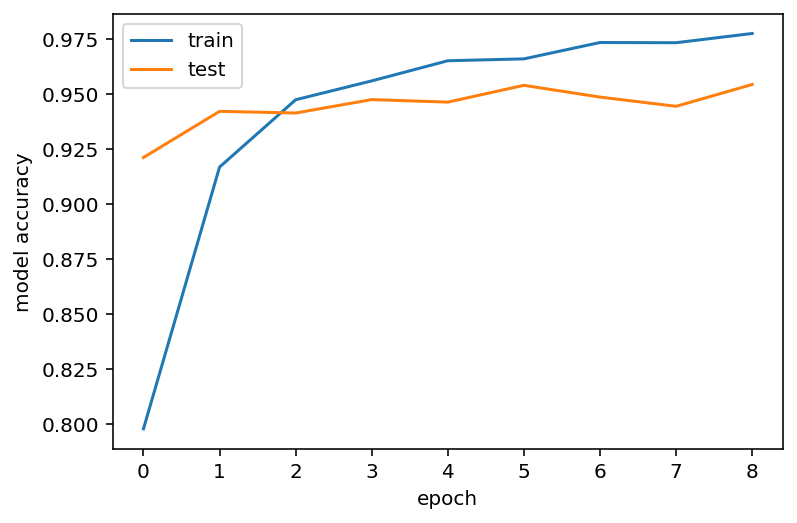

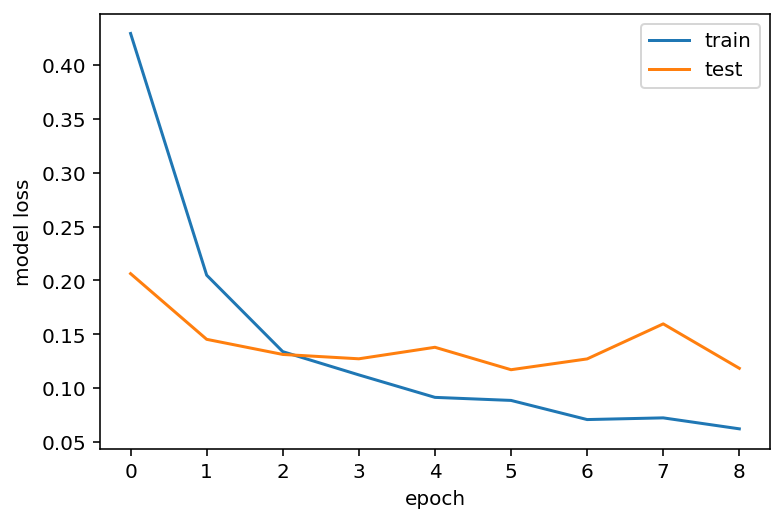

In [6]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Hyperparameters tuning
Use scikit-learn to grid search the batch size and epochs

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20, 50, 100]
epochs = [5, 10, 15]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))